1.	Data Extraction

In [2]:
from selenium import webdriver
from bs4 import BeautifulSoup
from tqdm import tqdm
import pandas as pd
import time
import json

# ✅ Funksiya: Sahifadan ma'lumotlarni ajratish
def get_movie_details_selenium(driver, url):
    try:
        driver.get(url)
        time.sleep(2.5)
        soup = BeautifulSoup(driver.page_source, "html.parser")

        title_tag = soup.find("h1")
        title = title_tag.text.strip() if title_tag else None

        year_tag = soup.select_one("ul li a[href*='releaseinfo']")
        year = year_tag.text.strip() if year_tag else None

        rating_tag = soup.find("span", {"class": "sc-bde20123-1"})
        rating = rating_tag.text.strip() if rating_tag else None

        votes_tag = soup.select_one("div.sc-bde20123-3 span.sc-bde20123-2")
        votes = votes_tag.text.replace(",", "") if votes_tag else None

        genres = [g.text for g in soup.select("div.ipc-chip-list--baseAlt a span")]

        director_section = soup.select_one("li[data-testid='title-pc-principal-credit']")
        directors = [a.text.strip() for a in director_section.select("a")] if director_section else []

        cast_section = soup.select("a[data-testid='title-cast-item__actor']")
        cast = [actor.text.strip() for actor in cast_section[:3]]

        runtime_tag = soup.select_one("li[data-testid='title-techspec_runtime'] span")
        runtime = runtime_tag.text.replace("m", "").strip() if runtime_tag else None

        gross_tag = soup.find("li", attrs={"data-testid": "title-boxoffice-cumulativeworldwidegross"})
        box_office = gross_tag.find_all("span")[-1].text.strip() if gross_tag else None

        return {
            "Title": title,
            "Year": year,
            "Rating": rating,
            "Votes": votes,
            "Genres": genres,
            "Directors": directors,
            "Cast": cast,
            "Runtime": runtime,
            "Box Office": box_office
        }

    except Exception as e:
        print(f"❌ Xatolik: {url} → {e}")
        return None

# ✅ 1. Linklar JSON fayldan
with open("movie_links.json", "r", encoding="utf-8") as f:
    movie_links = json.load(f)

# ✅ 2. Chrome browser sozlash (ko‘rinadigan)
options = webdriver.ChromeOptions()
# options.add_argument("--headless")  # istasangiz oching
driver = webdriver.Chrome(options=options)

movie_data = []
failed_links = []

# ✅ 3. Scraping boshlanadi
for i, url in enumerate(tqdm(movie_links[:250], desc="IMDb scraping")):
    details = get_movie_details_selenium(driver, url)
    if details:
        movie_data.append(details)
    else:
        failed_links.append(url)
    time.sleep(1.5)

driver.quit()

# ✅ 4. CSV ga yozish
df = pd.DataFrame(movie_data)
df.to_csv("imdb_top_250_movies_fixed.csv", index=False, encoding="utf-8-sig")
print("✅ CSV saqlandi: imdb_top_250_movies_fixed.csv")

# ✅ 5. Xatoliklar logi
if failed_links:
    with open("failed_links.json", "w", encoding="utf-8") as f:
        json.dump(failed_links, f, indent=2)
    print(f"❗ {len(failed_links)} ta linkda xatolik bo‘ldi. → failed_links.json ga saqlandi.")
else:
    print("🎉 Hamma linklar muvaffaqiyatli yuklandi.")


IMDb scraping: 100%|██████████| 250/250 [44:31<00:00, 10.69s/it]


✅ CSV saqlandi: imdb_top_250_movies_fixed.csv
🎉 Hamma linklar muvaffaqiyatli yuklandi.


In [5]:
import pandas as pd
from selenium import webdriver
from bs4 import BeautifulSoup
import time
import json
from tqdm import tqdm

# 1. CSV fayldan barcha filmlar ro‘yxatini o‘qiymiz
df = pd.read_csv("imdb_top_250_movies_fixed.csv")

# 2. Havolalarni JSON fayldan yuklaymiz
with open("movie_links.json", "r", encoding="utf-8") as f:
    movie_links = json.load(f)

# 3. Chrome ochamiz
options = webdriver.ChromeOptions()
# options.add_argument("--headless")  # Kerak bo‘lsa, oynasiz
driver = webdriver.Chrome(options=options)

# 4. Har bir sahifadan Runtime yig‘amiz
runtime_minutes = []

for url in tqdm(movie_links, desc="Runtime yig‘ilmoqda"):
    driver.get(url)
    time.sleep(2)
    soup = BeautifulSoup(driver.page_source, "html.parser")

    # Runtime topish
    runtime = None
    runtime_tag = soup.find("li", {"data-testid": "title-techspec_runtime"})
    if runtime_tag:
        span = runtime_tag.find("span")
        if span:
            text = span.text.strip()
            try:
                # Misollar: "2h 22m", "1h 55m", "148m"
                h, m = 0, 0
                if "h" in text:
                    h_part = text.split("h")
                    h = int(h_part[0].strip())
                    if "m" in h_part[1]:
                        m = int(h_part[1].replace("m", "").strip())
                elif "m" in text:
                    m = int(text.replace("m", "").strip())
                runtime = h * 60 + m
            except:
                runtime = None
    runtime_minutes.append(runtime)

driver.quit()

# 5. CSV faylga qo‘shamiz
df["Runtime"] = runtime_minutes

# 6. Yangi CSV saqlaymiz
df.to_csv("imdb_top_250_with_runtime.csv", index=False, encoding="utf-8-sig")
print("✅ Yangi fayl saqlandi: imdb_top_250_with_runtime.csv")


Runtime yig‘ilmoqda: 100%|██████████| 250/250 [37:46<00:00,  9.07s/it]


✅ Yangi fayl saqlandi: imdb_top_250_with_runtime.csv


In [12]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time
import json
from tqdm import tqdm

# Fayllarni ochamiz
df = pd.read_csv("imdb_top_250_with_runtime.csv")
with open("movie_links.json", "r", encoding="utf-8") as f:
    movie_links = json.load(f)

# Selenium browser sozlash
options = webdriver.ChromeOptions()
# options.add_argument("--headless")  # Ko‘rinadigan rejimda ochamiz
driver = webdriver.Chrome(options=options)

# Ma'lumotlar saqlanadi
updated_runtime = []
updated_rating = []
updated_votes = []

# Funksiya
import re

def get_details(url):
    try:
        driver.get(url)
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.TAG_NAME, "h1"))
        )
        time.sleep(1.5)
        soup = BeautifulSoup(driver.page_source, "html.parser")

        ### ✅ Rating (YANGI selector bilan)
        try:
            rating_tag = soup.select_one("div[data-testid='hero-rating-bar__aggregate-rating__score'] span")
            rating = float(rating_tag.text.strip()) if rating_tag else None
        except Exception as e:
            print(f"⚠️ Rating xatolik: {e}")
            rating = None

        ### ✅ Votes (YANGI selector bilan)
        try:
            votes_tag = soup.select_one("div[data-testid='hero-rating-bar__aggregate-rating__score'] ~ div span")
            votes = int(votes_tag.text.replace(",", "").strip()) if votes_tag else None
        except Exception as e:
            print(f"⚠️ Votes xatolik: {e}")
            votes = None

        ### ✅ Runtime (regex asosida)
        try:
            runtime = None
            runtime_tag = soup.find("li", {"data-testid": "title-techspec_runtime"})
            if runtime_tag:
                text = runtime_tag.text.strip().lower()
                h_match = re.search(r"(\d+)\s*h", text)
                m_match = re.search(r"(\d+)\s*m", text)
                h = int(h_match.group(1)) if h_match else 0
                m = int(m_match.group(1)) if m_match else 0
                runtime = h * 60 + m if (h or m) else None
        except Exception as e:
            print(f"⚠️ Runtime xatolik: {e}")
            runtime = None

        return runtime, rating, votes

    except Exception as e:
        print(f"❌ {url} - umumiy xatolik: {e}")
        return None, None, None


# 250 ta filmni aylantirish
print("🔁 Ma'lumotlar to‘planmoqda...")
for url in tqdm(movie_links, desc="IMDb scraping"):
    r_time, r_rating, r_votes = get_details(url)
    updated_runtime.append(r_time)
    updated_rating.append(r_rating)
    updated_votes.append(r_votes)
    time.sleep(1.5)

driver.quit()

# CSVga qo‘shish
df["Runtime"] = updated_runtime
df["Rating"] = updated_rating
df["Votes"] = updated_votes

df.to_csv("imdb_top_250_final_clean.csv", index=False, encoding="utf-8-sig")
print("✅ Yangi fayl saqlandi: imdb_top_250_final_clean.csv")


🔁 Ma'lumotlar to‘planmoqda...


IMDb scraping: 100%|██████████| 250/250 [47:17<00:00, 11.35s/it] 


✅ Yangi fayl saqlandi: imdb_top_250_final_clean.csv


In [13]:
def get_votes_only(url):
    try:
        driver.get(url)
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.TAG_NAME, "h1"))
        )
        time.sleep(1.5)
        soup = BeautifulSoup(driver.page_source, "html.parser")

        # YANGI votes selector
        votes_tag = soup.select_one("div[data-testid='hero-rating-bar__aggregate-rating__score'] ~ div span")
        votes = int(votes_tag.text.replace(",", "").strip()) if votes_tag else None

        return votes
    except Exception as e:
        print(f"❌ Votes olishda xatolik: {url} - {e}")
        return None


In [15]:
import pandas as pd
import json
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
from tqdm import tqdm

# 1. Fayllarni ochamiz
df = pd.read_csv("imdb_top_250_votes_filled.csv")
with open("movie_links.json", "r", encoding="utf-8") as f:
    movie_links = json.load(f)

# 2. Votes ustunidagi bo‘sh indexlarni aniqlaymiz
votes_nan_indexes = df[df["Votes"].isnull()].index.tolist()
votes_links = [movie_links[i] for i in votes_nan_indexes]

# 3. Selenium Chrome driver ishga tushadi
options = webdriver.ChromeOptions()
# options.add_argument("--headless")  # kerak bo‘lsa, oynasiz
driver = webdriver.Chrome(options=options)

# 4. Faol votes yig‘uvchi funksiya
def get_votes_only(url):
    try:
        driver.get(url)
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.TAG_NAME, "h1"))
        )
        time.sleep(1.5)
        soup = BeautifulSoup(driver.page_source, "html.parser")

        votes = None
        # Sahifada votes ko‘rinadigan joydan olish
        tag = soup.find("div", {"data-testid": "hero-rating-bar__aggregate-rating__score"})
        if tag:
            parent = tag.find_parent()
            votes_tag = parent.find_all("span")[-1]
            if votes_tag:
                votes_text = votes_tag.text.strip().replace(",", "").replace("K", "000")
                votes = int(''.join(filter(str.isdigit, votes_text)))

        return votes
    except Exception as e:
        print(f"❌ Votes xatolik: {url} → {e}")
        return None

# 5. Votes qiymatlarini yig‘amiz
updated_votes = []
print("🔁 Votes qiymatlari yig‘ilmoqda...")

for url in tqdm(votes_links, desc="Votes scraping"):
    vote = get_votes_only(url)
    updated_votes.append(vote)
    time.sleep(1.5)

driver.quit()

# 6. Yig‘ilgan votes qiymatlarini to‘g‘ri joylarga qo‘yamiz
for idx, v in zip(votes_nan_indexes, updated_votes):
    df.at[idx, "Votes"] = v

# 7. CSV faylga yozamiz
df.to_csv("imdb_top_250_votes_final.csv", index=False, encoding="utf-8-sig")
print("✅ Yangi fayl saqlandi: imdb_top_250_votes_final.csv")


🔁 Votes qiymatlari yig‘ilmoqda...


Votes scraping: 100%|██████████| 250/250 [48:13<00:00, 11.58s/it] 


✅ Yangi fayl saqlandi: imdb_top_250_votes_final.csv


2.	Data Ingestion & Cleaning

In [ ]:
import pandas as pd
import numpy as np

# Faylni yuklash
df = pd.read_csv("/mnt/data/imdb_top_250_votes_final.csv")

# 1. 'Votes' — millionga ko‘paytirib int formatga o‘tkazamiz
df['Votes'] = (df['Votes'] * 1_000_000).astype('Int64')

# 2. 'Box Office' — $, vergulni olib tashlab, int formatga o‘tkazamiz
df['Box Office'] = df['Box Office'].replace('Noma\'lum', None)
df['Box Office'] = df['Box Office'].str.replace('[\$,]', '', regex=True)
df['Box Office'] = pd.to_numeric(df['Box Office'], errors='coerce').astype('Int64')

# 3. Genres, Directors, Cast — stringdan listga aylantiramiz
list_columns = ['Genres', 'Directors', 'Cast']
for col in list_columns:
    df[col] = df[col].apply(lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else [])

# 4. Saqlash
cleaned_path = "/mnt/data/imdb_top_250_movies_cleaned.csv"
df.to_csv(cleaned_path, index=False)

cleaned_path


Har bir filmga ID berib chiqamiz

In [18]:
df = pd.read_csv("imdb_top_250_movies_cleaned.csv")
df.insert(0, "MovieID", df.index + 1)  # 1 dan boshlab raqam beriladi
df.to_csv("imdb_top_250_movies_final.csv", index=False, encoding="utf-8-sig")
print("✅ Final CSV saqlandi: imdb_top_250_movies_final.csv")


✅ Final CSV saqlandi: imdb_top_250_movies_final.csv


3	Data Modeling & Transformation

In [21]:
df = pd.read_csv("imdb_top_250_movies_final.csv")

#Genres, Directors, Cast ustunlari .eval() bilan list shakliga o‘tkazildi
df["Genres"] = df["Genres"].apply(eval)
df["Directors"] = df["Directors"].apply(eval)
df["Cast"] = df["Cast"].apply(eval)

#.explode() bilan bir-to-ko‘p (one-to-many) munosabatlar yaratildi:
df_genres = df[["MovieID", "Title", "Genres"]].explode("Genres").rename(columns={"Genres": "Genre"})
df_directors = df[["MovieID", "Title", "Directors"]].explode("Directors").rename(columns={"Directors": "Director"})
df_cast = df[["MovieID", "Title", "Cast"]].explode("Cast").rename(columns={"Cast": "Actor"})



In [ ]:
df.pd.read_csv("imdb_top_250_movies_final.csv")

4.KPIlar va statistikalar

In [ ]:

# 1. Top 10 eng ko‘p uchraydigan janrlar

import pandas as pd

df = pd.read_csv("imdb_top_250_movies_final.csv")
df["Genres"] = df["Genres"].apply(eval)

df_exploded_genres = df[["Title", "Genres"]].explode("Genres")
top_genres = df_exploded_genres["Genres"].value_counts().head(10).reset_index()
top_genres.columns = ["Genre", "Film Count"]

top_genres.style.set_caption("🎬 Top 10 Genres by Film Count")


,Genre,Film Count
0,Drama,190
1,Epic,57
2,Adventure,57
3,Crime,52
4,Thriller,52
5,Tragedy,51
6,Period Drama,51
7,Psychological Drama,47
8,Comedy,46
9,Action,43


In [26]:
#2. Eng ko‘p film ishlagan aktyorlar
df["Cast"] = df["Cast"].apply(eval)

df_exploded_cast = df[["Title", "Cast"]].explode("Cast")
top_actors = df_exploded_cast["Cast"].value_counts().head(10).reset_index()
top_actors.columns = ["Actor", "Film Count"]

top_actors.style.set_caption("🎭 Top 10 Actors by Number of Films")


,Actor,Film Count
0,Robert De Niro,9
1,Leonardo DiCaprio,6
2,Harrison Ford,6
3,Tom Hanks,6
4,Christian Bale,5
5,Clint Eastwood,5
6,Charles Chaplin,5
7,Matt Damon,5
8,Toshirô Mifune,4
9,Kevin Spacey,4


In [27]:
#3. Eng yuqori reytingga ega rejissyorlar (o‘rtacha bo‘yicha)
df["Directors"] = df["Directors"].apply(eval)

df_exploded_directors = df[["Directors", "Rating"]].explode("Directors")
top_directors = df_exploded_directors.groupby("Directors")["Rating"].mean().sort_values(ascending=False).head(10).reset_index()
top_directors.columns = ["Director", "Average Rating"]

top_directors.style.set_caption("🎬 Top 10 Directors by Average Rating")


,Director,Average Rating
0,Frank Darabont,8.950000
1,Peter Jackson,8.900000
2,Francis Ford Coppola,8.866667
3,Lana Wachowski,8.700000
4,Irvin Kershner,8.700000
5,Ertem Egilmez,8.700000
6,Vidhu Vinod Chopra,8.700000
7,Lilly Wachowski,8.700000
8,Robert Zemeckis,8.650000
9,Kátia Lund,8.600000


In [28]:
#4. Janrlar bo‘yicha o‘rtacha reyting
df_exploded_genres_rating = df[["Genres", "Rating"]].explode("Genres")
genre_avg_rating = df_exploded_genres_rating.groupby("Genres")["Rating"].mean().sort_values(ascending=False).head(10).reset_index()
genre_avg_rating.columns = ["Genre", "Average Rating"]

genre_avg_rating.style.set_caption("⭐ Top 10 Genres by Average IMDb Rating")


,Genre,Average Rating
0,Mountain Adventure,9.000000
1,Medical Drama,8.700000
2,Gun Fu,8.700000
3,Prison Drama,8.616667
4,Sword & Sorcery,8.614286
5,Western Epic,8.600000
6,Sci-Fi Epic,8.550000
7,Slasher Horror,8.550000
8,Action Epic,8.540000
9,Fantasy Epic,8.533333


In [ ]:
#5. Yil bo‘yicha reyting tendensiyasi
yearly_avg_rating = df.groupby("Year")["Rating"].mean().reset_index().sort_values("Year")

yearly_avg_rating.style.set_caption("📈 Yearly Average IMDb Rating")


In [ ]:
#6. Eng yuqori reytingga ega 10 ta film
import pandas as pd

# Ma'lumotlarni yuklaymiz
df = pd.read_csv("imdb_top_250_movies_final.csv")

# Rating bo‘yicha tartiblab, eng yuqori 10 talikni olamiz
top_rated = df[["Title", "Year", "Rating"]].sort_values(by="Rating", ascending=False).head(10)

# Jadval sarlavhasi bilan chiqamiz
top_rated.style.set_caption("⭐ Eng Yuqori Reytingga Ega 10 Film")


,Title,Year,Rating
0,Побег из Шоушенка,1994,9.300000
1,Крестный отец,1972,9.200000
2,Тёмный рыцарь,2008,9.000000
3,Крестный отец 2,1974,9.000000
4,12 разгневанных мужчин,1957,9.000000
5,Властелин колец: Возвращение короля,2003,9.000000
6,Список Шиндлера,1993,9.000000
7,Криминальное чтиво,1994,8.900000
8,Властелин колец: Братство кольца,2001,8.900000
11,Властелин колец: Две крепости,2002,8.800000


In [31]:
#7. Eng katta box office daromadga ega 10 ta film
# Box Office ustunini tozalash va float formatga o‘tkazish (agar hali tozalanmagan bo‘lsa)
df["Box Office"] = df["Box Office"].replace('[\$,]', '', regex=True).astype(float)

# Eng daromadli 10 filmni tanlaymiz
top_box_office = df[["Title", "Year", "Box Office"]].sort_values(by="Box Office", ascending=False).head(10)

# Jadvalni chiroyli chiqamiz
top_box_office.style.set_caption("💰 Eng Katta Box Office Daromadga Ega 10 Film")


<>:3: SyntaxWarning: invalid escape sequence '\$'
<>:3: SyntaxWarning: invalid escape sequence '\$'
C:\Users\user\AppData\Local\Temp\ipykernel_10528\1552001632.py:3: SyntaxWarning: invalid escape sequence '\$'
  df["Box Office"] = df["Box Office"].replace('[\$,]', '', regex=True).astype(float)


,Title,Year,Box Office
74,Мстители: Финал,2019,2799439100.000000
60,Мстители: Война бесконечности,2018,2052415039.000000
184,Человек-паук: Нет пути домой,2021,1921426073.000000
145,Топ Ган. Мэверик,2022,1495696292.000000
177,Гарри Поттер и Дары смерти: Часть II,2011,1439798701.000000
5,Властелин колец: Возвращение короля,2003,1138585547.000000
70,Тёмный рыцарь: Возрождение легенды,2012,1114976407.000000
140,Парк юрского периода,1993,1104379926.000000
85,Джокер,2019,1078958629.000000
92,История игрушек: Большой побег,2010,1067316101.000000


5.	Reporting & Visualization

Eng ko‘p uchraydigan janrlar


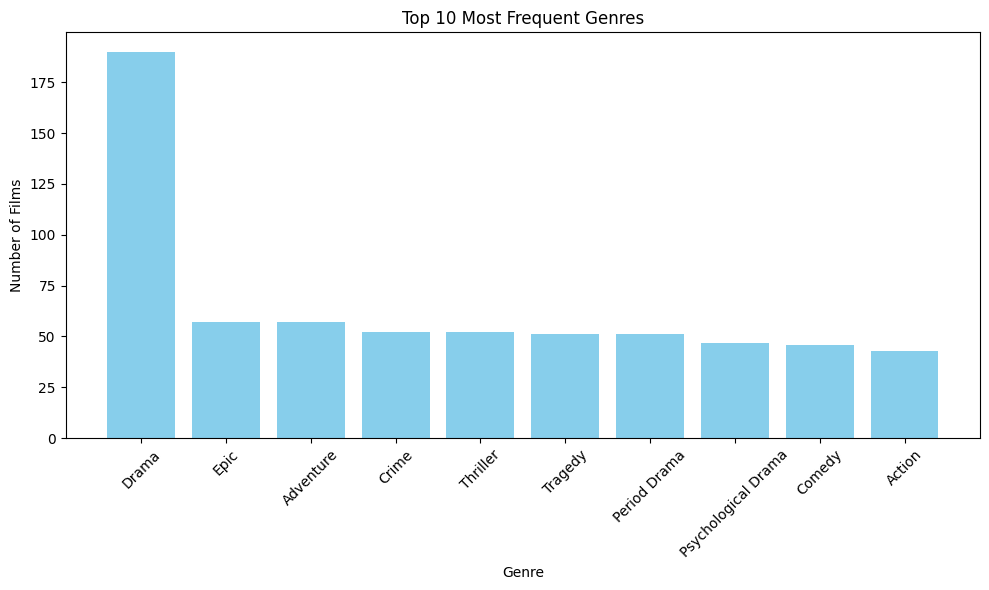

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(top_genres["Genre"], top_genres["Film Count"], color='skyblue')
plt.title("Top 10 Most Frequent Genres")
plt.xlabel("Genre")
plt.ylabel("Number of Films")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Eng ko‘p film ishlagan aktyorlar"

,Actor,Film Count
0,Robert De Niro,9
1,Leonardo DiCaprio,6
2,Harrison Ford,6
3,Tom Hanks,6
4,Christian Bale,5
5,Clint Eastwood,5
6,Charles Chaplin,5
7,Matt Damon,5
8,Toshirô Mifune,4
9,Kevin Spacey,4


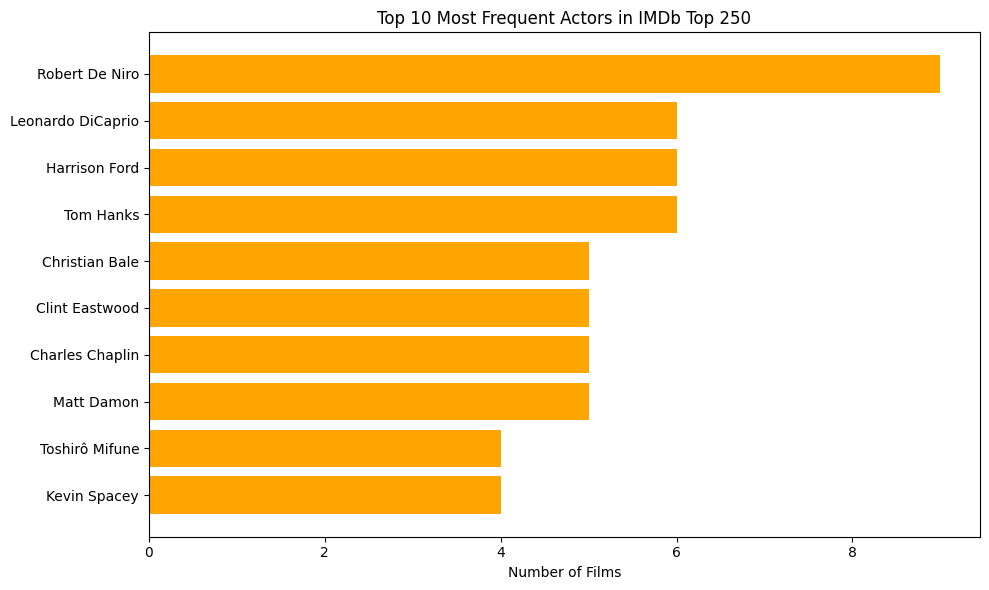

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. CSV faylni o‘qiymiz
df = pd.read_csv("imdb_top_250_movies_final.csv")

# 2. Cast ustunini list formatga o‘tkazamiz (agar string bo‘lsa)
df["Cast"] = df["Cast"].apply(eval)

# 3. Har bir aktyorni alohida satrga chiqaramiz
df_exploded_cast = df[["Title", "Cast"]].explode("Cast")


# 6. 📈 Bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_actors["Actor"], top_actors["Film Count"], color="orange")
plt.xlabel("Number of Films")
plt.title("Top 10 Most Frequent Actors in IMDb Top 250")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Eng yuqori reytingga ega 10 ta rejissyor

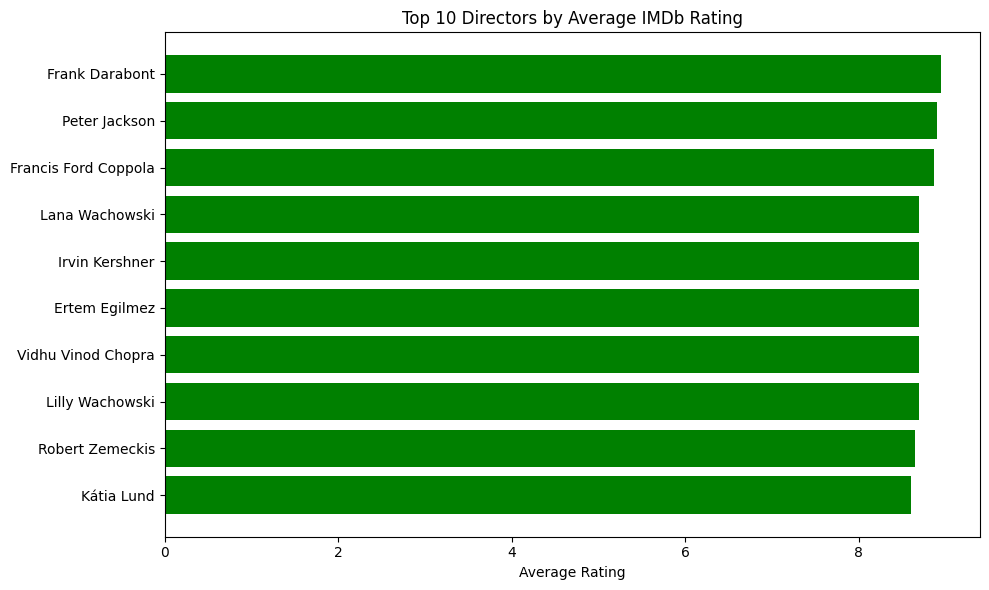

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Ma'lumotlarni yuklaymiz
df = pd.read_csv("imdb_top_250_movies_final.csv")

# 2. Directors ustunini list shakliga o‘tkazamiz (eval bilan)
df["Directors"] = df["Directors"].apply(eval)

# 3. Har bir rejissyorni alohida satrga explode qilamiz
df_exploded_directors = df[["Directors", "Rating"]].explode("Directors")



# 6. 📈 Bar chart chizish
plt.figure(figsize=(10, 6))
plt.barh(top_directors["Director"], top_directors["Average Rating"], color="green")
plt.xlabel("Average Rating")
plt.title("Top 10 Directors by Average IMDb Rating")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Daromadi eng katta bo‘lgan 10 film

<>:8: SyntaxWarning: invalid escape sequence '\$'
<>:8: SyntaxWarning: invalid escape sequence '\$'
C:\Users\user\AppData\Local\Temp\ipykernel_10528\72424644.py:8: SyntaxWarning: invalid escape sequence '\$'
  df["Box Office"] = df["Box Office"].replace('[\$,]', '', regex=True).astype(float)


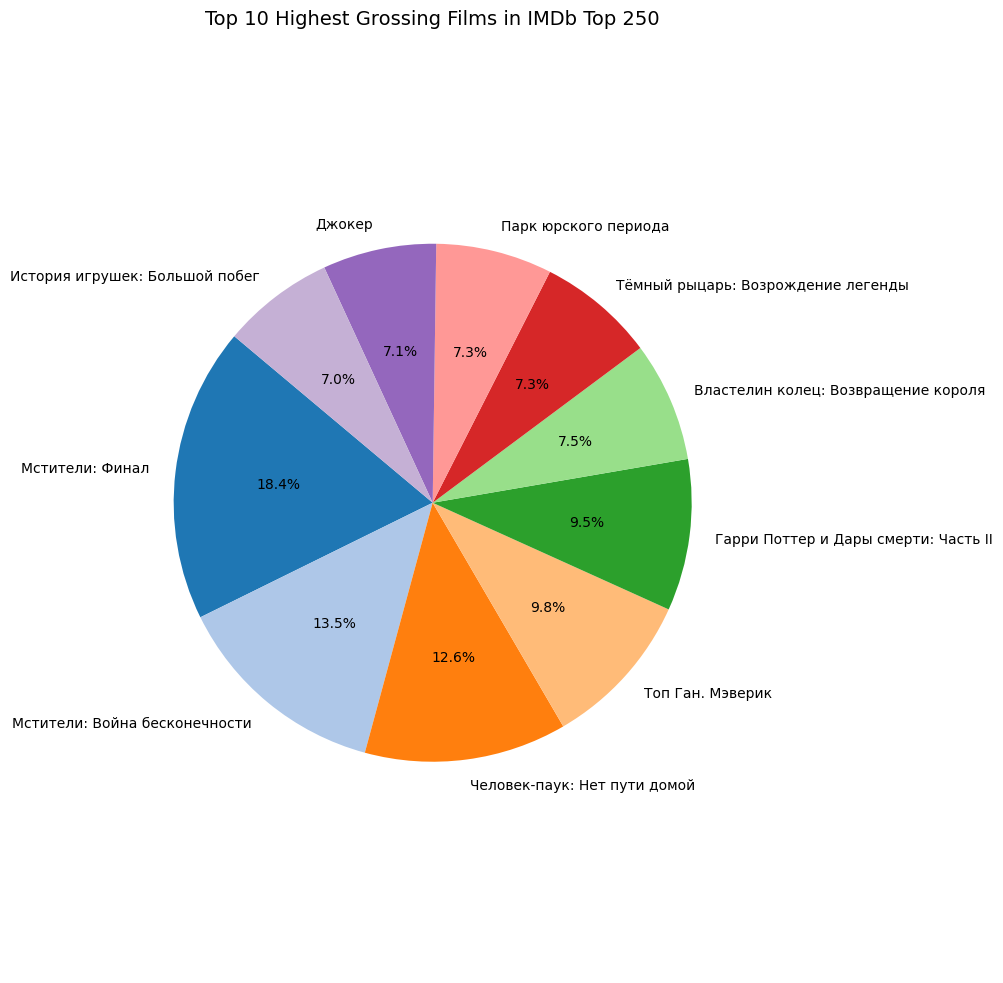

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. CSV faylni yuklaymiz
df = pd.read_csv("imdb_top_250_movies_final.csv")

# 2. Box Office ustunini tozalaymiz va float formatga o‘tkazamiz
df["Box Office"] = df["Box Office"].replace('[\$,]', '', regex=True).astype(float)

# 3. Eng daromadli 10 filmni ajratamiz
top_box_office = df[["Title", "Box Office"]].sort_values(by="Box Office", ascending=False).head(10)

# 4. 📈 Pie chart chizamiz
plt.figure(figsize=(10, 10))
plt.pie(
    top_box_office["Box Office"],
    labels=top_box_office["Title"],
    autopct="%1.1f%%",
    startangle=140,
    colors=plt.cm.tab20.colors
)
plt.title("Top 10 Highest Grossing Films in IMDb Top 250", fontsize=14)
plt.axis("equal")  # doira shaklida chiqaradi
plt.tight_layout()
plt.show()

IMDb reytingi eng yuqori bo‘lgan 10 film

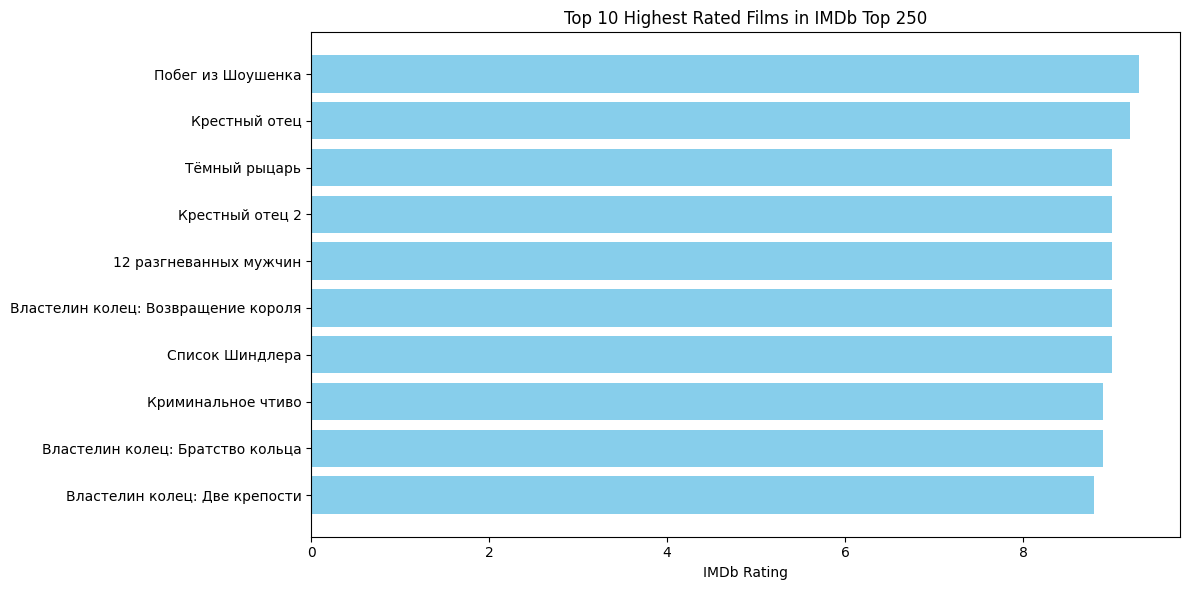

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Ma'lumotlarni yuklaymiz
df = pd.read_csv("imdb_top_250_movies_final.csv")

# 2. Eng yuqori reytingga ega 10 ta filmni tanlaymiz
top_rated = df[["Title", "Rating"]].sort_values(by="Rating", ascending=False).head(10)

# 3. 📈 Bar chart
plt.figure(figsize=(12, 6))
plt.barh(top_rated["Title"], top_rated["Rating"], color="skyblue")
plt.xlabel("IMDb Rating")
plt.title("Top 10 Highest Rated Films in IMDb Top 250")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Yil bo‘yicha reyting tendensiyasi

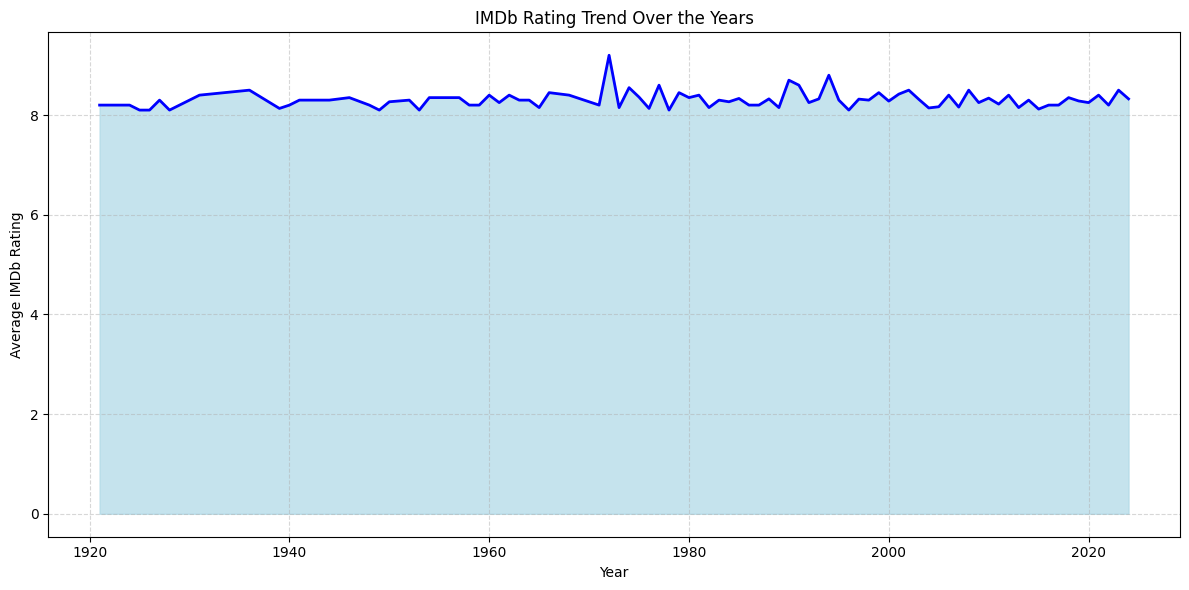

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. CSV faylni o‘qiymiz
df = pd.read_csv("imdb_top_250_movies_final.csv")

# 2. Yil bo‘yicha o‘rtacha reytingni hisoblaymiz
yearly_avg = df.groupby("Year")["Rating"].mean().reset_index().sort_values("Year")

# 3. 📈 Area plot (soha grafigi)
plt.figure(figsize=(12, 6))
plt.fill_between(yearly_avg["Year"], yearly_avg["Rating"], color="lightblue", alpha=0.7)
plt.plot(yearly_avg["Year"], yearly_avg["Rating"], color="blue", linewidth=2)
plt.title("IMDb Rating Trend Over the Years")
plt.xlabel("Year")
plt.ylabel("Average IMDb Rating")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
